# Environment Setting

In [1]:
IN_COLAB = False

try:
  import google.colab
  IN_COLAB = True
except:
  pass

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Tesi_GDrive
  PROJECT_PATH = '/content/gdrive/MyDrive/Tesi_GDrive'
  #!ls
else:
  %cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
  PROJECT_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os

if IN_COLAB == True:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))
else:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
#from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
#from tensorflow.keras import initializers
#from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

#from pkl import store_data, load_data
#from functions.compressor import compress
from functions.compressor_param import compress_2
from functions.mapping import sub2ind3d, ind2sub
from functions.policy_functions import policy_evaluation, policy_improvement, policy_iteration, policy_optim, value_iteration


import random
from collections import defaultdict

import time



print("Libraries imported")

/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive


2023-05-31 14:45:31.582797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported


## Data Loading

In [17]:
df_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/df_partitioned.csv')
df = pd.read_csv(df_path)

T_norm = np.load(os.path.join(PROJECT_PATH, 'MDP_data/kmeans/T_cluster_df_norm.npy'))
R_norm = np.load(os.path.join(PROJECT_PATH, 'MDP_data/kmeans/R_norm_kmeans.npy'))
T_st = np.load(os.path.join(PROJECT_PATH, 'MDP_data/kmeans/T_cluster_df_st.npy'))
R_st = np.load(os.path.join(PROJECT_PATH, 'MDP_data/kmeans/R_st_kmeans6.npy'))

T_group = [T_norm, T_st]
T_group_name = ['T_norm', 'T_st']
R_group = [R_norm, R_st]

## Policy Iteration

p_eval convergenza raggiunta
p_eval convergenza raggiunta
p_iteration convergenza raggiunta
policy:  [1. 1. 2. 1. 1.]
value:  [-0.34854682 -0.29699566 -0.31737617 -0.31493697 -0.30818466]


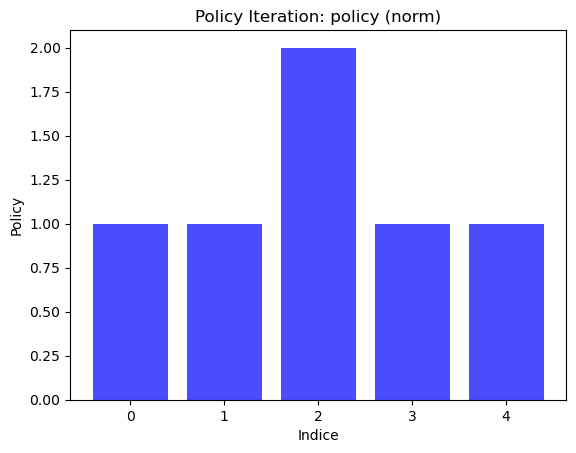

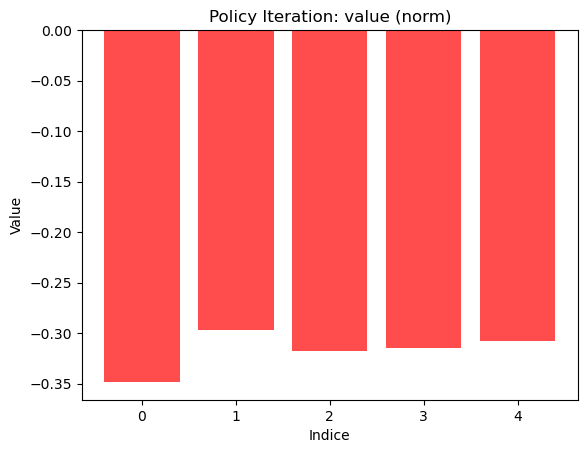

In [49]:
T = T_norm
R = R_norm

policy, value = policy_iteration(T=T, R=R, gamma=0.99)
policy = policy.reshape(-1)
print("policy: ", policy)
print("value: ", value)

# Numero di elementi sull'asse x
num_elements = len(policy)

# Crea un array di indici degli elementi sull'asse x
indices = np.arange(num_elements)

# Crea il primo istogramma per la policy
plt.bar(indices, policy, align='center', alpha=0.7, color='blue')
plt.xticks(indices, indices)
plt.xlabel('Indice')
plt.ylabel('Policy')
plt.title('Policy Iteration: policy (norm)')

# Mostra il primo istogramma
plt.show()

# Crea il secondo istogramma per il value
plt.bar(indices, value, align='center', alpha=0.7, color='red')
plt.xticks(indices, indices)
plt.xlabel('Indice')
plt.ylabel('Value')
plt.title('Policy Iteration: value (norm)')

# Mostra il secondo istogramma
plt.show()

p_eval convergenza raggiunta
p_eval convergenza raggiunta
p_eval convergenza raggiunta
p_iteration convergenza raggiunta
policy:  [ 612.   84. 1134.  270.  135. 1138.]
value:  [28.45149008 35.76869964 34.43884115 34.38175382 35.77062473  6.65623333]


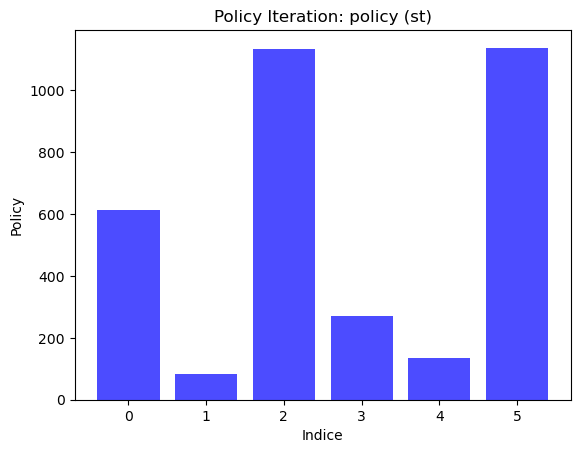

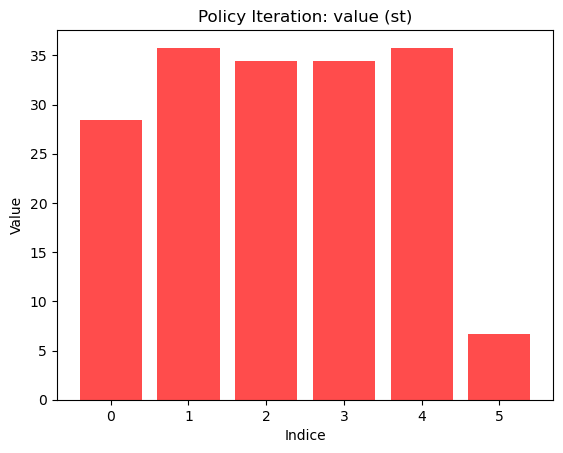

In [50]:
T = T_st
R = R_st

policy, value = policy_iteration(T=T, R=R, gamma=0.99)
policy = policy.reshape(-1)
print("policy: ", policy)
print("value: ", value)

# Numero di elementi sull'asse x
num_elements = len(policy)

# Crea un array di indici degli elementi sull'asse x
indices = np.arange(num_elements)

# Crea il primo istogramma per la policy
plt.bar(indices, policy, align='center', alpha=0.7, color='blue')
plt.xticks(indices, indices)
plt.xlabel('Indice')
plt.ylabel('Policy')
plt.title('Policy Iteration: policy (st)')

# Mostra il primo istogramma
plt.show()

# Crea il secondo istogramma per il value
plt.bar(indices, value, align='center', alpha=0.7, color='red')
plt.xticks(indices, indices)
plt.xlabel('Indice')
plt.ylabel('Value')
plt.title('Policy Iteration: value (st)')

# Mostra il secondo istogramma
plt.show()

## Value Iteration

value [[ 368]
 [ 681]
 [ 389]
 [1036]
 [ 139]]
v_iteration convergenza raggiunta
policy:  [1138. 1138. 1134.   81.   72.]
value:  [ 372.28853723 1004.3476572   384.43673032 1004.29436969  367.88815642]


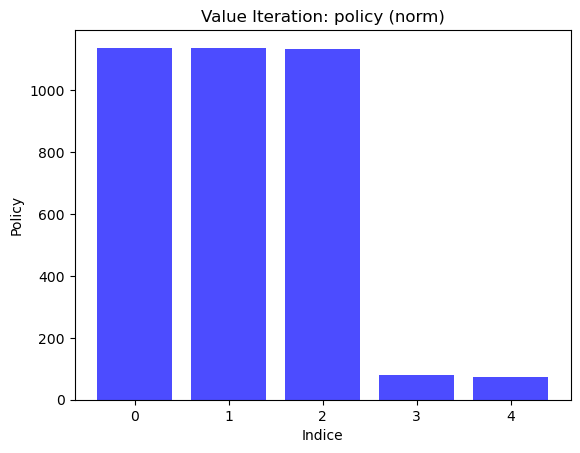

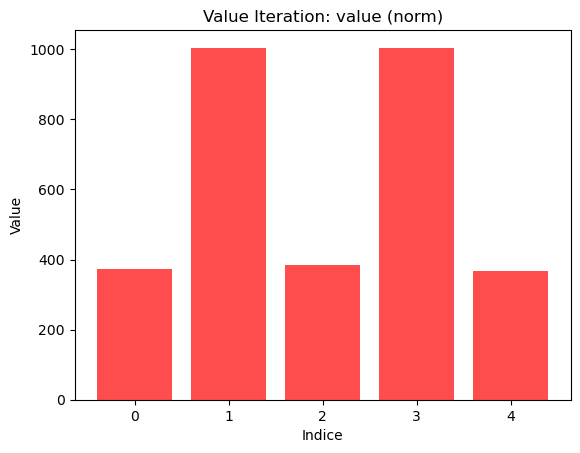

In [51]:
T = T_norm
R = R_norm

policy, value = value_iteration(T=T, R=R, gamma=0.99)
policy = policy.reshape(-1)
print("policy: ", policy)
print("value: ", value)

# Numero di elementi sull'asse x
num_elements = len(policy)

# Crea un array di indici degli elementi sull'asse x
indices = np.arange(num_elements)

# Crea il primo istogramma per la policy
plt.bar(indices, policy, align='center', alpha=0.7, color='blue')
plt.xticks(indices, indices)
plt.xlabel('Indice')
plt.ylabel('Policy')
plt.title('Value Iteration: policy (norm)')

# Mostra il primo istogramma
plt.show()

# Crea il secondo istogramma per il value
plt.bar(indices, value, align='center', alpha=0.7, color='red')
plt.xticks(indices, indices)
plt.xlabel('Indice')
plt.ylabel('Value')
plt.title('Value Iteration: value (norm)')

# Mostra il secondo istogramma
plt.show()


value [[ 597]
 [ 904]
 [ 750]
 [ 922]
 [ 538]
 [1150]]
v_iteration convergenza raggiunta
policy:  [ 486.  169. 1134.  270.  135. 1138.]
value:  [1105.51637294 1105.01133205 1106.08349169 1104.5632604  1105.95213132
 1093.91157153]


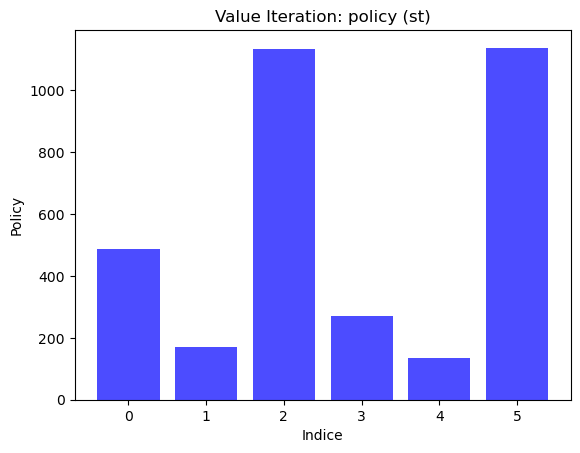

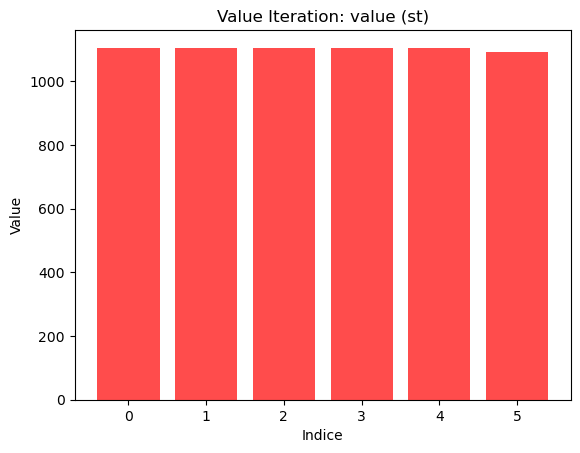

In [52]:
T = T_st
R = R_st

policy, value = value_iteration(T=T, R=R, gamma=0.99)
policy = policy.reshape(-1)
print("policy: ", policy)
print("value: ", value)

# Numero di elementi sull'asse x
num_elements = len(policy)

# Crea un array di indici degli elementi sull'asse x
indices = np.arange(num_elements)

# Crea il primo istogramma per la policy
plt.bar(indices, policy, align='center', alpha=0.7, color='blue')
plt.xticks(indices, indices)
plt.xlabel('Indice')
plt.ylabel('Policy')
plt.title('Value Iteration: policy (st)')

# Mostra il primo istogramma
plt.show()

# Crea il secondo istogramma per il value
plt.bar(indices, value, align='center', alpha=0.7, color='red')
plt.xticks(indices, indices)
plt.xlabel('Indice')
plt.ylabel('Value')
plt.title('Value Iteration: value (st)')

# Mostra il secondo istogramma
plt.show()

In [54]:
def ind2sub3d(ind, shape):
    """
    Restituisce un tuple di indici corrispondenti all'indice `ind` in un array tridimensionale di forma `shape`.
    
    Parameters:
        ind (int): L'indice da mappare.
        shape (tuple): La forma dell'array tridimensionale.
        
    Returns:
        tuple: Una tupla di indici corrispondenti all'indice `ind` nell'array tridimensionale.
    """
    rows = shape[0]
    cols = shape[1]
    slices = shape[2]
    row = ind // (cols * slices)
    col = (ind // slices) % cols
    slice_idx = ind % slices
    return (row, col, slice_idx)

In [62]:
def get_triplet_by_index(index, tuple_size):
    if index < 0 or index >= tuple_size ** 3:
        raise IndexError("L'indice specificato è fuori dai limiti della tupla.")
    
    z = index % tuple_size
    index //= tuple_size
    y = index % tuple_size
    index //= tuple_size
    x = index % tuple_size
    
    return (x, y, z)

(4, 8, 6)
(1, 6, 9)
(2, 7, 0)
(1, 3, 5)
